In [20]:
import numpy as np # 数据处理最重要的模块
import pandas as pd # 数据处理最重要的模块
import scipy.stats as stats # 统计模块
import scipy
# import pymysql  # 导入数据库模块

from datetime import datetime # 时间模块
import statsmodels.formula.api as smf  # OLS regression

# import pyreadr # read RDS file

from matplotlib import style
import matplotlib.pyplot as plt  # 画图模块
import matplotlib.dates as mdates

from matplotlib.font_manager import FontProperties # 作图中文
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.family'] = 'Times New Roman'

#输出矢量图 渲染矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.core.interactiveshell import InteractiveShell # jupyter运行输出的模块
#显示每一个运行结果
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_rows',8)
pd.set_option('display.max_columns', None)

# 股票市场回报率

In [ ]:
from pandas.tseries.offsets import MonthEnd # 月末
Market_ret = pd.read_csv('Marketret_mon_stock2024.csv')
Market_ret['month'] = pd.to_datetime(Market_ret['month'], format='%b %Y') + MonthEnd(0)
Market_ret.set_index('month', inplace=True)
Market_ret.sort_index(inplace=True)
# 删除名为 Unnamed: 0 的列
Market_ret = Market_ret.drop(columns=['Unnamed: 0'])
Market_ret   

,MarketR,MarketR_e,rfmonth,ret,ret_e,marketret3,marketret6,marketret12,Q
month,,,,,,,,,
1991-01-31,0.029998,0.036554,0.006930,0.023068,0.029624,-0.084127,-0.305662,0.254049,1991 Q1
1991-02-28,0.010203,0.021860,0.006930,0.003273,0.014930,-0.183573,-0.384745,0.241492,1991 Q1
1991-03-31,-0.099663,-0.060425,0.006930,-0.106593,-0.067355,-0.252928,-0.445049,0.288857,1991 Q1
1991-04-30,-0.079652,-0.031449,0.006651,-0.086303,-0.038100,-0.234776,-0.394937,0.691749,1991 Q2
...,...,...,...,...,...,...,...,...,...
2024-09-30,0.195992,0.227078,0.001118,0.194874,0.225960,0.200147,NaN,NaN,2024 Q3
2024-10-31,-0.003409,0.070220,0.001118,-0.004527,0.069102,0.000228,NaN,NaN,2024 Q4
2024-11-30,0.009724,0.045312,0.001118,0.008606,0.044194,NaN,NaN,NaN,2024 Q4
2024-12-31,-0.002679,-0.040799,0.001118,-0.003797,-0.041917,NaN,NaN,NaN,2024 Q4


In [23]:
inflation = pd.read_csv('inflation.csv')
inflation['month'] = pd.to_datetime(inflation['month'],format='%Y/%m/%d')
inflation.set_index('month',inplace=True)
inflation

,cpi
month,
1987-01-31,5.1
1987-02-28,5.4
1987-03-31,5.8
1987-04-30,6.7
...,...
2025-04-30,-0.1
2025-05-31,-0.1
2025-06-30,0.1
2025-07-31,0.0


In [ ]:
#加载、清洗并预处理三个不同的金融数据集
price_dividend = pd.read_csv('Price_dividend_mon2024.csv')
price_dividend['month'] = pd.date_range(start='1990-12-31', end='2024-12-31', freq='ME')
price_dividend.set_index('month', inplace=True)
price_dividend.sort_index(inplace=True)
price_dividend = price_dividend.drop(columns=['Unnamed: 0'])

price_earning = pd.read_csv('Price_earnings_mon2024.csv')
price_earning['month'] = pd.date_range(start='1991-01-31', end='2024-12-31', freq='ME')
price_earning.set_index('month', inplace=True)
price_earning.sort_index(inplace=True)

price_bookvalue = pd.read_csv('Price_bookvalue_mon2024.csv')
price_bookvalue['month'] = pd.date_range(start='1990-12-31', end='2024-12-31', freq='ME')
price_bookvalue.set_index('month', inplace=True)
price_bookvalue.sort_index(inplace=True)

# 月度数据的预测

A simple linear regression of an asset return on one or a few lagged predictors of interest is the most popular econometric approach for testing for return predictability. For simplicity, consider a univariate predictive regression of the period- $(t + 1)$ stock market return $r_{t+1}$ on a single predictor variable $x_t$:
$$
r_{t+1}=\alpha+\beta x_{t}+\varepsilon_{t+1}
$$
where $\varepsilon_{t+1}$ is a zero-mean, unpredictable disturbance term. When $x_t$ is the inflation rate, dividend yield, book-to-price ratio, or turnover. Many researchers find that $\beta$ is significantly different from zero; that is, there is in-sample evidence of stock market return predictability.

* H0:$\beta = 0$
* H1:$\beta \ne 0$(我们需要通过理论分析，得出$\beta$的符号)

## 股权溢价之谜 和 消费基础的资产定价

$$
r_{t} = \gamma E_{t-1}(cov(r,\Delta c))
$$

其中:
- $\Delta c$ 是消费增长率
- $cov(r,\Delta c)$ 是资产收益率与消费增长率的协方差
- 这个关系式来源于消费基础资产定价模型(C-CAPM)
- 历史数据显示美国股权溢价约为 6-8%

### 股权溢价之谜 (Equity Premium Puzzle)

**定义**: Mehra and Prescott (1985) 发现,用标准的经济模型很难解释历史上观察到的高股权溢价(股票收益率相对于无风险利率的超额收益)。

要解释历史上的高股权溢价,需要:
1. **非常高的风险厌恶系数** $\gamma$ (远超过合理的经济学估计值 2-10)
2. 或者**消费增长与股票收益的协方差非常高**(但实际数据中并非如此)

#### 可能的解释

1. **有限参与** (Limited Participation): 并非所有投资者都参与股票市场
2. **损失厌恶** (Loss Aversion): 投资者对损失比对收益更敏感
3. **灾难风险** (Rare Disaster Risk): 小概率极端事件的担忧 (Barro, 2006)
4. **长期风险** (Long-run Risk): 消费增长的持续性波动 (Bansal-Yaron, 2004)

- **消费数据**：宏观消费数据通常是按季度或年度发布的，存在显著的测量误差，并且会经历多次修正。这使得用它来检验高频的金融市场现象变得非常困难 。
- **市场回报数据**：股票市场的回报数据质量非常高，可以精确到每日甚至更高频率，且不存在修正问题。

### 理论溯源：跨期资本资产定价模型 (ICAPM)

该模型的理论基石是罗伯特·默顿（Robert Merton）在1973年提出的跨期资本资产定价模型（Intertemporal Capital Asset Pricing Model, ICAPM）。ICAPM的核心观点是，在一个动态的多时期世界里，理性的、风险规避的投资者不仅会因为承担当前的系统性风险而要求补偿，还会因为未来投资机会的变化（例如未来利率、市场波动率的变化）而要求额外的风险溢价。

ICAPM的一个关键推论是，市场组合的预期超额收益（Expected Excess Return）与它的条件方差（Conditional Variance）之间存在线性的正相关关系。条件方差衡量了在当前信息下对下一期市场波动性的预期，是市场风险的直接度量。因此，ICAPM预测了如下关系：

$$
E_{t-1}(r_{M,t}) = \gamma \cdot E_{t-1} \left (\sigma_{M,t}^2 \right)
$$

其中：
-   $E_{t-1}(r_{M,t})$ 是在 $t-1$ 时点对市场组合在 $t$ 时期的超额收益的期望。
-   $E_{t-1} \left (\sigma_{M,t}^2 \right)$ 是在 $t-1$ 时点对市场组合在 $t$ 时期的风险的期望。
-   $\gamma$ 代表了市场投资者的平均相对风险厌恶系数，也被称为“风险的价格”，它衡量了投资者为承担单位市场风险所要求的额外预期收益。


### 实证检验

本节通过检验以下关系:
$$
r_{t+1} = \alpha + \beta \cdot RV_t + \varepsilon_{t+1}
$$

其中 $RV_t$ 是已实现波动率(realized variance),作为条件方差 $E_t(\sigma^2_{t+1})$ 的估计。

**理论预期**: 如果 ICAPM 成立,应该有 $\beta > 0$ 且显著。

然而，在实际操作中：

$$
RV_t(k)=\sum_{d=1}^{D_t} r_{d, t}^2+2 \sum_{j=1}^k \sum_{d=j+1}^{D_t} r_{d, t} r_{d-j, t}
$$

### 计量实现：均值内ARCH (ARCH-in-Mean) 模型

为了在实际数据中检验ICAPM所预测的风险-收益关系，需要一个能够同时处理收益率均值和时变波动率（即异方差性）的计量模型。罗伯特·恩格尔（Robert Engle）等人于1987年提出的均值内自回归条件异方差模型（ARCH-in-Mean, ARCH-M）正是为此而生。

ARCH-M模型是对早期ARCH模型的扩展。标准的ARCH及后来更具一般性的GARCH模型，主要用于刻画金融时间序列中普遍存在的波动率聚类现象（volatility clustering），即高波动率时期和低波动率时期会各自聚集出现。这些模型的核心是建立一个独立的方程来描述条件方差 $\sigma_t^2$ 如何随时间变化，通常是过去残差平方和过去方差的函数。

ARCH-M模型的创新之处在于，它将条件方差（或条件标准差）作为一个解释变量引入到资产收益率的均值方程中。这使得研究者可以直接估计和检验风险（由 $\sigma_t^2$ 度量）对预期收益（$E_{t-1}(r_t)$）的影响。
$$
\begin{aligned}
r_t & =\mu+a_t  \\
\sigma_t^2 & =\alpha_0+\alpha_1 a_{t-1}^2+\beta_1 \sigma_{t-1}^2
\end{aligned}
$$
$$
\begin{aligned}
r_t & =\mu+c \sigma_t^2+a_t  \\
\sigma_t^2 & =\alpha_0+\alpha_1 a_{t-1}^2+\beta_1 \sigma_{t-1}^2
\end{aligned}
$$

### 核心参数的经济学含义

参数 $\gamma$ 的估计结果至关重要。
-   如果 $\gamma$ 显著为正，则支持了经典的金融理论，即存在正向的风险收益权衡关系：投资者在预期到未来市场波动性将加剧时，会要求更高的预期回报作为承担更高风险的补偿。
-   如果 $\gamma$ 不显著或为负，则对该理论提出了挑战。

值得注意的是，尽管理论上 $\gamma$ 应该为正，但在不同市场、不同时期和不同模型设定下的实证研究结果却并不一致，一些研究发现了显著为正的关系，而另一些研究则得到了不显著甚至为负的结果。

In [28]:
Market_ret_day = pd.read_excel('Marketret_day_stock2024.xlsx')
Market_ret_day['Day'] = pd.to_datetime(Market_ret_day['Day'],format='%Y-%m-%d')
Market_ret_day.set_index('Day',inplace=True)
Market_ret_day.sort_index(inplace=True)
Market_ret_day

,MarketR,MarketR_e,month,Q,rfday,er,er1,er2,er3,er4,neg_er,neg_er1,neg_er2,neg_er3,pos_er,pos_er1,pos_er2,pos_er3
Day,,,,,,,,,,,,,,,,,,
1990-12-20,0.050067,0.752547,12 1990,1990 Q4,0.000227,0.049840,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.049840,NaN,NaN,NaN
1990-12-21,0.039671,67.771445,12 1990,1990 Q4,0.000227,0.039444,0.049840,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.039444,0.049840,NaN,NaN
1990-12-24,0.049380,0.049638,12 1990,1990 Q4,0.000227,0.049153,0.039444,0.049840,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.049153,0.039444,0.049840,NaN
1990-12-25,0.049938,0.050022,12 1990,1990 Q4,0.000227,0.049711,0.049153,0.039444,0.049840,NaN,0.000000,0.000000,0.000000,0.000000,0.049711,0.049153,0.039444,0.049840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-26,0.002969,0.011729,12 2024,2024 Q4,0.000037,0.002932,-0.004398,0.012003,-0.009967,-0.000314,0.000000,-0.004398,0.000000,-0.009967,0.002932,0.000000,0.012003,0.000000
2024-12-27,0.002119,0.008489,12 2024,2024 Q4,0.000037,0.002082,0.002932,-0.004398,0.012003,-0.009967,0.000000,0.000000,-0.004398,0.000000,0.002082,0.002932,0.000000,0.012003
2024-12-30,0.000660,-0.008647,12 2024,2024 Q4,0.000037,0.000623,0.002082,0.002932,-0.004398,0.012003,0.000000,0.000000,0.000000,-0.004398,0.000623,0.002082,0.002932,0.000000
2024-12-31,-0.018452,-0.024026,12 2024,2024 Q4,0.000037,-0.018489,0.000623,0.002082,0.002932,-0.004398,-0.018489,0.000000,0.000000,0.000000,0.000000,0.000623,0.002082,0.002932


In [ ]:
#  基于日度超额收益数据，计算月度的 “已实现方差（Realized Variance, RV）
Market_variance = Market_ret_day.resample('ME').apply(lambda df: pd.Series({
    'RV': (df['er']**2).sum(), # 对一个月内每天的er²求和
    'RV1': (df['er']**2).sum() + 2*(df['er']*df['er1']).sum(), # 扩展的已实现方差（加入 1 阶滞后交叉项）
    'RV1': (df['er']**2).sum() + 2*(df['er']*df['er1']).sum(), 
    'RV2': (df['er']**2).sum() + 2*(df['er']*df['er1']).sum() + 2*(df['er']*df['er2']).sum(),
    'RV3': (df['er']**2).sum() + 2*(df['er']*df['er1']).sum() + 2*(df['er']*df['er2']).sum() + 2*(df['er']*df['er3']).sum()
}))
# 传统月度方差的计算
Market_variance['var'] = Market_ret_day.resample('ME')['er'].var()
Market_variance.index.name = 'month'
# 保证方差非负,实际中可能因数据误差（如er1/er2等滞后项数据缺失、计算错误）导致RV1/RV2/RV3为负
# if RV3 <0, set to RV2 if RV2 <0, set to RV1 if RV1 <0, set to RV
Market_variance['RV1'] = Market_variance['RV1'].where(Market_variance['RV1']>=0, Market_variance['RV'])
Market_variance['RV2'] = Market_variance['RV2'].where(Market_variance['RV2']>=0, Market_variance['RV1'])
Market_variance['RV3'] = Market_variance['RV3'].where(Market_variance['RV3']>=0, Market_variance['RV2'])
Market_variance

# market_variance <- daily_data[,.(MV = sum(er^2)),by = 'month'] This is R code

,RV,RV1,RV2,RV3,var
month,,,,,
1990-12-31,0.011709,0.030732,0.046608,0.058424,0.000395
1991-01-31,0.000690,0.001566,0.002593,0.003461,0.000030
1991-02-28,0.000418,0.000707,0.000853,0.000763,0.000024
1991-03-31,0.001229,0.002925,0.004650,0.006369,0.000014
...,...,...,...,...,...
2024-09-30,0.012481,0.023868,0.034838,0.041347,0.000593
2024-10-31,0.011652,0.007954,0.006707,0.006707,0.000685
2024-11-30,0.004019,0.004118,0.005938,0.003775,0.000201
2024-12-31,0.001713,0.001517,0.001623,0.001167,0.000082


In [31]:
reg_data = pd.merge(Market_ret,inflation,on = 'month')
reg_data = pd.merge(reg_data,Market_variance,on = 'month')
reg_data = pd.merge(reg_data,price_dividend,on = 'month')
reg_data = pd.merge(reg_data,price_earning,on = 'month')
reg_data = pd.merge(reg_data,price_bookvalue,on = 'month')
reg_data = reg_data[['MarketR','rfmonth','ret','cpi','RV','RV1','RV2','RV3','var','pd','pe','pb','marketret3','marketret6','marketret12']]
# Output reg_data to reg_data.csv
reg_data.to_csv('reg_data.csv')
# Output reg_data to reg_data.xlsx
reg_data.to_excel('reg_data.xlsx')

reg_data

,MarketR,rfmonth,ret,cpi,RV,RV1,RV2,RV3,var,pd,pe,pb,marketret3,marketret6,marketret12
month,,,,,,,,,,,,,,,
1991-01-31,0.029998,0.006930,0.023068,2.2,0.000690,0.001566,0.002593,0.003461,0.000030,NaN,4.466562,2.080065,-0.084127,-0.305662,0.254049
1991-02-28,0.010203,0.006930,0.003273,1.0,0.000418,0.000707,0.000853,0.000763,0.000024,NaN,4.501042,1.949285,-0.183573,-0.384745,0.241492
1991-03-31,-0.099663,0.006930,-0.106593,1.6,0.001229,0.002925,0.004650,0.006369,0.000014,NaN,4.112082,1.560324,-0.252928,-0.445049,0.288857
1991-04-30,-0.079652,0.006651,-0.086303,1.3,0.000855,0.001973,0.003364,0.004531,0.000010,NaN,4.111121,1.970330,-0.234776,-0.394937,0.691749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30,0.195992,0.001118,0.194874,0.4,0.012481,0.023868,0.034838,0.041347,0.000593,10.889979,2.675435,0.275764,0.200147,NaN,NaN
2024-10-31,-0.003409,0.001118,-0.004527,0.3,0.011652,0.007954,0.006707,0.006707,0.000685,10.862945,2.635010,0.254341,0.000228,NaN,NaN
2024-11-30,0.009724,0.001118,0.008606,0.2,0.004019,0.004118,0.005938,0.003775,0.000201,10.858076,2.643930,0.263924,NaN,NaN,NaN
2024-12-31,-0.002679,0.001118,-0.003797,0.1,0.001713,0.001517,0.001623,0.001167,0.000082,10.842070,2.652927,0.261665,NaN,NaN,NaN


## 作图 Plot

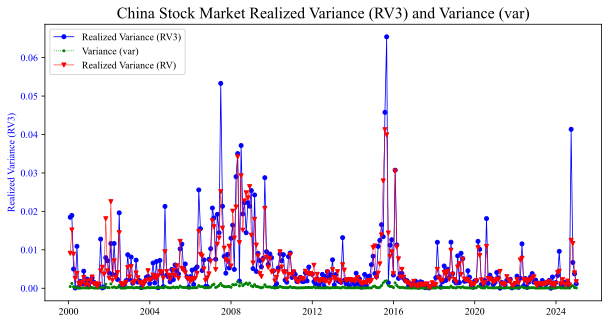

In [38]:
# 对比RV3和RV var
reg_data_plot = reg_data['2000-01':'2024-12'].copy()
# Plot the RV3 and var into one graph
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(reg_data_plot['RV3'],color='blue',marker='o',linewidth=0.8,
         markersize=4,
         linestyle='-',label='Realized Variance (RV3)')
ax1.set_ylabel('Realized Variance (RV3)',color='blue')
# 设置坐标轴上 “刻度”（tick）的各种属性
ax1.tick_params(axis='y', labelcolor='blue')   
ax1.set_title("China Stock Market Realized Variance (RV3) and Variance (var)", fontsize=16)

ax1.plot(reg_data_plot['var'],color='green',marker='.',linewidth=0.8,
         markersize=4,
         linestyle=':',label='Variance (var)')
ax1.plot(reg_data_plot['RV'],color='red',marker='v',linewidth=0.5,
         markersize=4,
         linestyle='-',label='Realized Variance (RV)')

ax1.legend(loc='upper left')
plt.show();

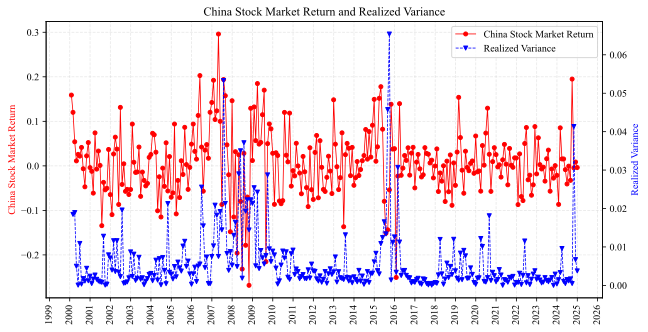

In [44]:
reg_data_plot = reg_data['2000-01':'2024-12'].copy()
# Plot the China's stock market return and inflation into one graph
fig, ax1 = plt.subplots(figsize=(10,5))
# the linewidth and marker size are set to be very small
ax1.plot(reg_data_plot['ret'],color='red',marker='o',linewidth=0.8,
         markersize=4,
         linestyle='-',label='China Stock Market Return')
ax1.set_ylabel('China Stock Market Return',color='red')
#ax1.set_xlabel('Month')

# 设置x轴的日期显示格式
data_format = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(data_format)
ax1.xaxis.set_major_locator(mdates.YearLocator())
# 增加网格线
ax1.grid(True, linestyle='--', alpha=0.3)
# 转置x轴的日期显示格式
plt.xticks(rotation = 90)


ax2 = ax1.twinx()
ax2.plot(reg_data_plot['RV3'].shift(1),color='blue',marker='v',linewidth=0.8,
         markersize=4,
         linestyle='--',label='Realized Variance')

ax2.set_ylabel('Realized Variance',color='blue')

plt.title('China Stock Market Return and Realized Variance')

# change the legend into one box
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.show();

## 描述性统计 Summary

In [45]:
reg_data['RV'].describe().round(5)

count    408.00000
mean       0.00876
std        0.01858
min        0.00027
25%        0.00189
50%        0.00357
75%        0.00882
max        0.25211
Name: RV, dtype: float64

In [ ]:
# 计算「偏度」(衡量的是数据分布相对于正态分布的「不对称程度」)
reg_data['RV'].skew()
# 计算「峰度」(衡量的是数据分布相对于正态分布的「峰值尖锐程度」和「尾部厚度」)
reg_data['RV'].kurt()

7.734617011548641

82.80411751131915

In [ ]:
from statsmodels.tsa.stattools import adfuller as ADF

# 对月收益率数据进行ADF检验
adf_result = ADF(reg_data[reg_data.index >= '2000-01-31']['RV'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}') # ADF统计量
print(f'p-value: {adf_result[1]:.4f}') # p值：假设检验的显著性水平，最直观的判断依据
print('Critical Values:')   # 不同置信水平下的阈值，用于对比 ADF 统计量
# 临界值
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -3.4302
p-value: 0.0100
Critical Values:
   1%: -3.4527
   5%: -2.8714
   10%: -2.5720
结论: p-value小于0.05，拒绝原假设，序列是平稳的。


## OLS 回归结果

In [81]:
# 研究滞后一期的波动率（lRV）对下一期的股票市场收益率（ret）是否有预测作用
reg_data['lRV'] = reg_data['RV'].shift(1)
model_cpi = smf.ols('ret ~ lRV',
                 data=reg_data['1995-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})# 计算自相关时考虑的最大滞后阶数
print(model_cpi.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.2224
Date:                Sun, 16 Nov 2025   Prob (F-statistic):              0.637
Time:                        16:53:37   Log-Likelihood:                 390.73
No. Observations:                 360   AIC:                            -777.5
Df Residuals:                     358   BIC:                            -769.7
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0099      0.005      1.923      0.0

In [109]:
# 研究 滞后两期的通货膨胀率（lcpi）对股票市场收益率（ret）的预测作用。
reg_data['lcpi'] = reg_data['cpi'].shift(2)
model_cpi = smf.ols('ret ~ lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpi.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     7.293
Date:                Sun, 16 Nov 2025   Prob (F-statistic):            0.00732
Time:                        16:53:52   Log-Likelihood:                 354.12
No. Observations:                 300   AIC:                            -704.2
Df Residuals:                     298   BIC:                            -696.8
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0213      0.007      2.874      0.0

In [ ]:
# 研究 滞后一期的波动率（lRV）和滞后两期的通货膨胀率（lcpi） 这两个变量 共同对股票市场收益率（ret）的预测作用
model_twovariables = smf.ols('ret ~ lRV + lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_twovariables.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     3.773
Date:                Sun, 16 Nov 2025   Prob (F-statistic):             0.0241
Time:                        16:53:52   Log-Likelihood:                 354.12
No. Observations:                 300   AIC:                            -702.2
Df Residuals:                     297   BIC:                            -691.1
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0212      0.008      2.611      0.0

In [136]:
# 研究 滞后一期的波动率（lRV）、滞后一期的价格股息比（lpd）和滞后两期的通货膨胀率（lcpi） 这三个变量 共同对股票市场收益率（ret）的预测作用
reg_data['lpd'] = reg_data['pd'].shift(1)
model3 = smf.ols('ret ~ lRV + lpd + lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     2.581
Date:                Sun, 16 Nov 2025   Prob (F-statistic):             0.0537
Time:                        16:55:08   Log-Likelihood:                 354.45
No. Observations:                 300   AIC:                            -700.9
Df Residuals:                     296   BIC:                            -686.1
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0826      0.088      0.937      0.3

## 季度结果

In [161]:
# Calculate monthly realized variance (RV) by summing squared excess returns
# 季度已实现方差（RV）的计算
Market_variance_Q = Market_ret_day.resample('QE').apply(lambda df: pd.Series({
    'RV': (df['er']**2).sum(),
    'RV1': (df['er']**2).sum() + 2*(df['er']*df['er1']).sum(),
    'RV2': (df['er']**2).sum() + 2*(df['er']*df['er1']).sum() + 2*(df['er']*df['er2']).sum(),
    'RV3': (df['er']**2).sum() + 2*(df['er']*df['er1']).sum() + 2*(df['er']*df['er2']).sum() + 2*(df['er']*df['er3']).sum()
}))

Market_variance_Q['var'] = Market_ret_day.resample('QE')['er'].var()
Market_variance_Q.index.name = 'month'

# if RV3 <0, set to RV2 if RV2 <0, set to RV1 if RV1 <0, set to RV
Market_variance_Q['RV1'] = Market_variance_Q['RV1'].where(Market_variance_Q['RV1']>=0, Market_variance_Q['RV'])
Market_variance_Q['RV2'] = Market_variance_Q['RV2'].where(Market_variance_Q['RV2']>=0, Market_variance_Q['RV1'])
Market_variance_Q['RV3'] = Market_variance_Q['RV3'].where(Market_variance_Q['RV3']>=0, Market_variance_Q['RV2'])
Market_variance_Q.index.name = 'Q'
Market_variance_Q

,RV,RV1,RV2,RV3,var
Q,,,,,
1990-12-31,0.011709,0.030732,0.046608,0.058424,0.000395
1991-03-31,0.002337,0.005198,0.008096,0.010593,0.000032
1991-06-30,0.006177,0.008025,0.008207,0.010588,0.000067
1991-09-30,0.119336,0.114575,0.105919,0.105381,0.001495
...,...,...,...,...,...
2024-03-31,0.009678,0.012825,0.014335,0.013999,0.000170
2024-06-30,0.004243,0.002390,0.003917,0.003171,0.000073
2024-09-30,0.015241,0.026383,0.037398,0.042365,0.000236
2024-12-31,0.017384,0.013589,0.014268,0.003617,0.000290


In [ ]:
# Market_ret_day复合成季收益率数据
Q_marketret = reg_data['1995-01':'2024-12'].resample('QE').apply(
    lambda df: pd.Series({
        'MarketR': np.prod(1 + df['MarketR']) - 1,
        'rfqtr': np.prod(1 + df['rfmonth']) - 1,
        'cpi': sum(df['cpi']),
        'pd': df['pd'].iloc[-1], # 获取该季度最后一个月的价格股息比（pd）作为整个季度的价格股息比。
        'pe': df['pe'].iloc[-1],
        'pb': df['pb'].iloc[-1]
    })
)
Q_marketret['ret'] = Q_marketret['MarketR'] - Q_marketret['rfqtr']
Q_marketret.index.name = 'Q'
Q_marketret

,MarketR,rfqtr,cpi,pd,pe,pb,ret
Q,,,,,,,
1995-03-31,-0.014687,0.026386,6.780000e+01,11.798194,2.844483,0.866200,-0.041073
1995-06-30,-0.037718,0.026386,5.920000e+01,11.432152,2.655143,0.667672,-0.064104
1995-09-30,0.115336,0.026386,4.440000e+01,11.317123,2.777629,0.732792,0.088951
1995-12-31,-0.181765,0.026386,3.340000e+01,11.207058,2.572886,0.556556,-0.208151
...,...,...,...,...,...,...,...
2024-03-31,0.010521,0.003699,-8.326673e-17,10.831573,2.559242,0.195646,0.006822
2024-06-30,-0.030634,0.003604,8.000000e-01,10.770461,2.557868,0.136221,-0.034238
2024-09-30,0.159005,0.003424,1.500000e+00,10.889979,2.675435,0.275764,0.155581
2024-12-31,0.003586,0.003358,6.000000e-01,10.842070,2.652927,0.261665,0.000228


In [ ]:
# 合并数据
Qreg_data = pd.merge(Q_marketret,Market_variance_Q,on = 'Q')
Qreg_data

,MarketR,rfqtr,cpi,pd,pe,pb,ret,RV,RV1,RV2,RV3,var
Q,,,,,,,,,,,,
1995-03-31,-0.014687,0.026386,6.780000e+01,11.798194,2.844483,0.866200,-0.041073,0.035401,0.036770,0.030744,0.026817,0.000610
1995-06-30,-0.037718,0.026386,5.920000e+01,11.432152,2.655143,0.667672,-0.064104,0.165481,0.233823,0.240724,0.114255,0.002626
1995-09-30,0.115336,0.026386,4.440000e+01,11.317123,2.777629,0.732792,0.088951,0.018665,0.016207,0.015538,0.018267,0.000289
1995-12-31,-0.181765,0.026386,3.340000e+01,11.207058,2.572886,0.556556,-0.208151,0.013791,0.008836,0.011401,0.019522,0.000210
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,0.010521,0.003699,-8.326673e-17,10.831573,2.559242,0.195646,0.006822,0.009678,0.012825,0.014335,0.013999,0.000170
2024-06-30,-0.030634,0.003604,8.000000e-01,10.770461,2.557868,0.136221,-0.034238,0.004243,0.002390,0.003917,0.003171,0.000073
2024-09-30,0.159005,0.003424,1.500000e+00,10.889979,2.675435,0.275764,0.155581,0.015241,0.026383,0.037398,0.042365,0.000236
2024-12-31,0.003586,0.003358,6.000000e-01,10.842070,2.652927,0.261665,0.000228,0.017384,0.013589,0.014268,0.003617,0.000290


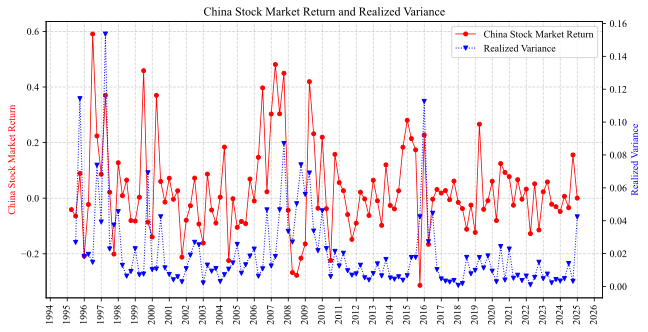

In [227]:
# Plot the China's stock market return and inflation into one graph
fig, ax1 = plt.subplots(figsize=(10,5))
# the linewidth and marker size are set to be very small
ax1.plot(Qreg_data['ret'],color='red',marker='o',linewidth=0.8,
         markersize=4,
         linestyle='-',label='China Stock Market Return')
ax1.set_ylabel('China Stock Market Return',color='red')
#ax1.set_xlabel('Month')

# 设置x轴的日期显示格式
data_format = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(data_format)
ax1.xaxis.set_major_locator(mdates.YearLocator())

# 转置x轴的日期显示格式
plt.xticks(rotation = 90)

ax2 = ax1.twinx()
ax2.plot(Qreg_data['RV3'].shift(1),color='blue',marker='v',linewidth=1,
         markersize=4,
         linestyle=':',label='Realized Variance')

ax2.set_ylabel('Realized Variance',color='blue')

plt.title('China Stock Market Return and Realized Variance')
ax1.grid(True, linestyle='--', alpha=0.6)
# change the legend into one box
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# save figure
fig.savefig('images/China Stock Market Return and Realized Variance Quarter.png',dpi = 1000,bbox_inches='tight')

plt.show();

In [ ]:
# 在季度数据层面，分别检验四种不同的滞后波动率指标对下一季度股票超额收益率的预测能力
Qreg_data['lRV'] = Qreg_data['RV'].shift(1)
Qreg_data['lRV1'] = Qreg_data['RV1'].shift(1)
Qreg_data['lRV2'] = Qreg_data['RV2'].shift(1)
Qreg_data['lRV3'] = Qreg_data['RV3'].shift(1)
model_qrv = smf.ols('ret ~ lRV',
                 data=Qreg_data['1995-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_qrv1 = smf.ols('ret ~ lRV1',
                 data=Qreg_data['1995-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_qrv2 = smf.ols('ret ~ lRV2',
                 data=Qreg_data['1995-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_qrv3 = smf.ols('ret ~ lRV3',
                 data=Qreg_data['1995-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})

# print all model summaries together
# 将四个模型的详细回归结果（summary）依次打印出来。
print("=" * 80)
print("Model with lRV:")
print("=" * 80)
print(model_qrv.summary())
print("\n" + "=" * 80)
print("Model with lRV1:")
print("=" * 80)
print(model_qrv1.summary())
print("\n" + "=" * 80)
print("Model with lRV2:")
print("=" * 80)
print(model_qrv2.summary())
print("\n" + "=" * 80)
print("Model with lRV3:")
print("=" * 80)
print(model_qrv3.summary())
# print all model summaries together

Model with lRV:
                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.070
Date:                Sun, 16 Nov 2025   Prob (F-statistic):              0.303
Time:                        17:07:18   Log-Likelihood:                 46.659
No. Observations:                 119   AIC:                            -89.32
Df Residuals:                     117   BIC:                            -83.76
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0135      0.017    

In [ ]:
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
# 使用 stargazer 库将你之前运行的四个独立的回归模型的结果整合成一个清晰、专业、易于比较的表格
stargazer = Stargazer([model_qrv, model_qrv1, model_qrv2, model_qrv3])
stargazer.title("回归结果对比分析")
stargazer.custom_columns(['模型一', '模型二', '模型三', '模型四'])
stargazer.show_model_numbers(False) # 控制是否在每个列名前显示模型编号
stargazer.show_confidence_intervals(False) # 控制是否在系数下方显示置信区间

# 生成HTML格式
html_output = stargazer.render_html()
HTML(html_output)

In [ ]:
# 使用 summary_col 进行多模型对比（推荐用于Jupyter）
# 都是对多个回归模型的结果进行汇总和对比
from statsmodels.iolib.summary2 import summary_col

# 创建对比表
results_table = summary_col(
    [model_qrv, model_qrv1, model_qrv2, model_qrv3],
    model_names=['RV', 'RV1', 'RV2', 'RV3'],
    stars=True,
    float_format='%.3f',
    info_dict={
        'N': lambda x: f"{int(x.nobs)}"
    }
)

print("\n 使用 statsmodels 的 summary_col（显示t值）\n")
print(results_table)


 使用 statsmodels 的 summary_col（显示t值）


                  RV     RV1     RV2     RV3  
----------------------------------------------
Intercept      0.014   0.016   0.009   -0.002 
               (0.017) (0.016) (0.017) (0.018)
lRV            0.812                          
               (0.785)                        
lRV1                   0.628                  
                       (0.543)                
lRV2                           0.991*         
                               (0.589)        
lRV3                                   1.501**
                                       (0.699)
R-squared      0.012   0.012   0.031   0.050  
R-squared Adj. 0.003   0.003   0.022   0.042  
N              119     119     119     119    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## 波动率和价格比率

In [268]:
# 在季度数据层面，研究 “滞后波动率” 与三种不同的 “滞后估值比率”结合后，对下一季度股票超额收益率（ret）的预测能力
Qreg_data['lpd'] = Qreg_data['pd'].shift(1)
Qreg_data['lpb'] = Qreg_data['pb'].shift(1)
Qreg_data['lpe'] = Qreg_data['pe'].shift(1)
model1 = smf.ols('ret ~ lRV + lpb',
                    data=Qreg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model2 = smf.ols('ret ~ lRV + lpe',
                    data=Qreg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model3 = smf.ols('ret ~ lRV + lpd',
                    data=Qreg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})

# 创建对比表
results_table = summary_col(
    [model1, model2, model3],
    model_names=['PB模型', 'PE模型', 'PD模型'],
    stars=True,
    float_format='%.3f',
    info_dict={ #添加了样本量 N 的信息
        'N': lambda x: f"{int(x.nobs)}"
    }
)
print(results_table)


                 PB模型    PE模型    PD模型 
--------------------------------------
Intercept      0.045   0.130   0.261  
               (0.034) (0.104) (0.292)
lRV            1.299   1.059   1.054  
               (1.429) (1.483) (1.461)
lpb            -0.058                 
               (0.041)                
lpe                    -0.042         
                       (0.035)        
lpd                            -0.022 
                               (0.026)
R-squared      0.032   0.024   0.019  
R-squared Adj. 0.012   0.004   -0.002 
N              100     100     100    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [ ]:
# 在季度数据层面，系统地研究在控制了最有效的滞后波动率指标（lRV3）后，三种不同的滞后估值比率（lpb, lpe, lpd）是否能为预测下一季度股票超额收益率（ret）提供额外的、显著的信息
model = smf.ols('ret ~ lRV3',
                    data=Qreg_data['1995-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model1 = smf.ols('ret ~ lRV3 + lpb',
                    data=Qreg_data['1995-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model2 = smf.ols('ret ~ lRV3 + lpe',
                    data=Qreg_data['1995-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model3 = smf.ols('ret ~ lRV3 + lpd',
                    data=Qreg_data['1995-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})

# 创建对比表
results_table = summary_col(
    [model, model1, model2, model3],
    model_names=['RV3', 'PB', 'PE', 'PD'],
    stars=True,
    float_format='%.3f',
    info_dict={
        'N': lambda x: f"{int(x.nobs)}"
    }
)
print(results_table)


                 RV3      PB       PE      PD  
-----------------------------------------------
Intercept      -0.002  0.044*   0.151*  0.277  
               (0.018) (0.027)  (0.082) (0.190)
lRV3           1.501** 1.808*** 1.674** 1.641**
               (0.699) (0.699)  (0.719) (0.710)
lpb                    -0.065**                
                       (0.030)                 
lpe                             -0.052*        
                                (0.027)        
lpd                                     -0.024 
                                        (0.017)
R-squared      0.050   0.078    0.071   0.062  
R-squared Adj. 0.042   0.062    0.055   0.046  
N              119     119      119     119    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [ ]:
# 不仅单独考察了波动率、估值比率和通胀率的预测作用，还深入分析了它们之间的交互效应和组合预测能力
Qreg_data['lcpi'] = Qreg_data['cpi'].shift(1)
model = smf.ols('ret ~ lRV3',
                    data=Qreg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model1 = smf.ols('ret ~ lRV3 + lpb',
                    data=Qreg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model2 = smf.ols('ret ~ lRV3 + lpe',
                    data=Qreg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model3 = smf.ols('ret ~ lRV3 + lpd',
                    data=Qreg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
# 这一组模型在 “波动率 + 单个估值比率” 的基础上，再加入通胀率 lcpi
model4 = smf.ols('ret ~ lRV3 + lcpi',
                    data=Qreg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model5 = smf.ols('ret ~ lRV3 + lpb + lcpi',
                    data=Qreg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model6 = smf.ols('ret ~ lRV3 + lpe + lcpi',
                    data=Qreg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model7 = smf.ols('ret ~ lRV3 + lpd + lcpi',
                    data=Qreg_data['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})

# 创建对比表
results_table = summary_col(
    [model, model1, model2, model3, model4, model5, model6, model7],
    model_names=['RV3', 'PB', 'PE', 'PD', 'CPI', 'PB+CPI', 'PE+CPI', 'PD+CPI'],
    stars=True,
    float_format='%.3f',
    info_dict={
        'N': lambda x: f"{int(x.nobs)}"
    }
)
print(results_table)


                 RV3      PB      PE      PD      CPI      PB+CPI    PE+CPI    PD+CPI 
--------------------------------------------------------------------------------------
Intercept      -0.004  0.039   0.135   0.295   0.038     0.083**   0.257**   0.484*   
               (0.020) (0.032) (0.098) (0.289) (0.029)   (0.037)   (0.110)   (0.266)  
lRV3           1.530   1.925   1.710   1.693   2.075**   2.496**   2.433**   2.366**  
               (1.242) (1.210) (1.248) (1.227) (1.035)   (1.063)   (1.077)   (1.075)  
lpb                    -0.067*                           -0.070**                     
                       (0.039)                           (0.035)                      
lpe                            -0.048                              -0.073**           
                               (0.033)                             (0.034)            
lpd                                    -0.026                                -0.039*  
                                       (0.

# GARCH-in-Mean 模型

## GARCH-in-Mean 模型理论

GARCH-in-Mean（GARCH-M）模型是检验 ICAPM 理论的标准计量工具，由 Engle, Lilien 和 Robins (1987) 提出。

### 模型设定

GARCH-M 模型包含两个方程：

**均值方程 (Mean Equation)**:
$$
r_t = \mu + \lambda \sigma_t^2 + \varepsilon_t
$$

**方差方程 (Variance Equation)**:
$$
\sigma_t^2 = \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2
$$

其中：
- $r_t$ 是资产的超额收益率
- $\sigma_t^2$ 是条件方差（预期波动率）
- $\lambda$ 是**风险溢价系数**（risk premium coefficient），对应 ICAPM 中的 $\gamma$
- $\omega > 0$, $\alpha \geq 0$, $\beta \geq 0$, 且 $\alpha + \beta < 1$ 保证平稳性
- $\varepsilon_t \sim N(0, \sigma_t^2)$ 是随机扰动项

### 参数的经济学含义

1. **$\lambda$ (lambda)**: 
   - 衡量投资者承担单位风险所要求的补偿
   - **理论预期**: $\lambda > 0$（风险厌恶的投资者要求正的风险溢价）
   - 如果 $\lambda$ 显著为正，支持 ICAPM 的风险-收益权衡假说

2. **$\alpha$ (alpha)**: 
   - ARCH 效应，衡量过去冲击对当前波动率的影响
   - 反映市场对"新闻"的反应程度

3. **$\beta$ (beta)**: 
   - GARCH 效应，衡量波动率的持续性
   - $\beta$ 越大，波动率聚类现象越明显

4. **$\alpha + \beta$**: 
   - 波动率的持久性指标
   - 接近 1 表示冲击对波动率有长期影响（高度持久）
   - 等于 1 时称为 IGARCH（积分 GARCH）

### 假设检验

**核心假设**:
- H₀: $\lambda = 0$ (风险对收益无影响)
- H₁: $\lambda > 0$ (存在正的风险-收益权衡)

**GARCH 效应检验**:
- H₀: $\alpha = 0$ and $\beta = 0$ (不存在 GARCH 效应)
- H₁: $\alpha > 0$ or $\beta > 0$ (存在 GARCH 效应)

In [ ]:
# GARCH-in-Mean 模型拟合（使用 ARCHInMean）
from arch.univariate import ARCHInMean, GARCH, Normal
# 使用 arch 库拟合一个 GARCH (1,1)-in-Mean 模型，该模型旨在同时捕捉金融时间序列的两个关键特征：时变波动率（通过 GARCH 模型）和风险 - 收益权衡（通过 in-Mean 部分）
# 准备数据：选择时间段并转换为百分比单位
garch_data = Market_ret_day.loc['2000-01-01':'2024-12-31', ['er']].copy() * 100
garch_data = garch_data.dropna()

# 使用 ARCHInMean 构建 GARCH(1,1)-in-Mean 模型
print("="*80)
print("GARCH(1,1)-in-Mean 模型估计")
print("="*80)

# 创建 GARCH-in-Mean 模型
# ARCHInMean 是专门用于 GARCH-in-Mean 的均值模型
model_garch_m = ARCHInMean(garch_data['er'], volatility=GARCH())

res = model_garch_m.fit(disp='off')

print(res.summary())

GARCH(1,1)-in-Mean 模型估计
                      ARCH-in-mean - GARCH Model Results                      
Dep. Variable:                     er   R-squared:                       0.000
Mean Model:              ARCH-in-mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -10434.7
Distribution:                  Normal   AIC:                           20879.5
Method:            Maximum Likelihood   BIC:                           20913.0
                                        No. Observations:                 6058
Date:                Sun, Nov 16 2025   Df Residuals:                     6056
Time:                        17:26:36   Df Model:                            2
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const         -0.1205  4.991e-02     

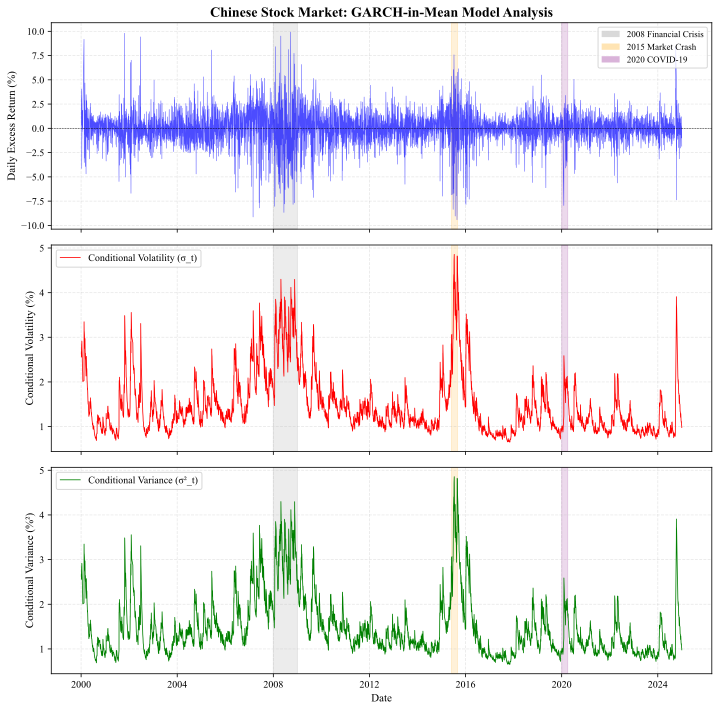

In [300]:
# Visualization: Conditional Volatility and Returns
import matplotlib.pyplot as plt

# Extract conditional volatility and variance from fitted results
conditional_volatility = res.conditional_volatility
conditional_variance = conditional_volatility
returns = garch_data['er']

# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# First plot: Returns
ax1.plot(returns.index, returns.values, color='blue', linewidth=0.5, alpha=0.7, label='Excess Returns')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax1.set_ylabel('Daily Excess Return (%)', fontsize=11)
ax1.set_title('Chinese Stock Market: GARCH-in-Mean Model Analysis', fontsize=14, fontweight='bold')
ax1.grid(True, linestyle='--',alpha=0.3)
ax1.legend(loc='upper left')

# Second plot: Conditional Volatility (Standard Deviation)
ax2.plot(conditional_volatility.index, conditional_volatility.values, 
         color='red', linewidth=0.8, label='Conditional Volatility (σ_t)')
ax2.set_ylabel('Conditional Volatility (%)', fontsize=11)
ax2.grid(True,linestyle='--',alpha=0.3)
ax2.legend(loc='upper left')

# Third plot: Conditional Variance
ax3.plot(conditional_variance.index, conditional_variance.values, 
         color='green', linewidth=0.8, label='Conditional Variance (σ²_t)')
ax3.set_ylabel('Conditional Variance (%²)', fontsize=11)
ax3.set_xlabel('Date', fontsize=11)
ax3.grid(True, linestyle='--',alpha=0.3)
ax3.legend(loc='upper left')

# Mark important events on all subplots
for ax in [ax1, ax2, ax3]:
    # 2008 Financial Crisis
    ax.axvspan(pd.Timestamp('2008-01-01'), pd.Timestamp('2009-01-01'), 
               alpha=0.15, color='gray')
    # 2015 Stock Market Crash
    ax.axvspan(pd.Timestamp('2015-06-01'), pd.Timestamp('2015-09-01'), 
               alpha=0.15, color='orange')
    # 2020 COVID-19 Pandemic
    ax.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-04-01'), 
               alpha=0.15, color='purple')

# Add legend for historical events on the first plot
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='gray', alpha=0.3, label='2008 Financial Crisis'),
    Patch(facecolor='orange', alpha=0.3, label='2015 Market Crash'),
    Patch(facecolor='purple', alpha=0.3, label='2020 COVID-19')
]
ax1.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.savefig('images/GARCH_M_Complete_Analysis.png', dpi=300, bbox_inches='tight')
plt.show();

In [ ]:
# GARCH-in-Mean Model with Monthly Data
# 用月度数据拟合一个 “带外生解释变量（滞后市净率）的 GARCH (1,1)-in-Mean 模型”
from arch.univariate import ARCHInMean, GARCH, Normal
reg_data['lpb'] = reg_data['pb'].shift(1)
# Prepare monthly data: select time period and convert to percentage
reg_mon = reg_data.loc['2000-01':'2024-12', ['ret','lpb']].copy() 
reg_mon['ret'] = reg_mon['ret'] * 100
reg_mon = reg_mon.dropna()

# Build GARCH(1,1)-in-Mean model with monthly data
print("="*80)
print("GARCH(1,1)-in-Mean Model Estimation (Monthly Data)")
print("="*80)

# Create GARCH-in-Mean model
model_garch_m_mon = ARCHInMean(y=reg_mon['ret'],x=reg_mon['lpb'], volatility=GARCH())

res_mon = model_garch_m_mon.fit(disp='off')

print(res_mon.summary())

GARCH(1,1)-in-Mean Model Estimation (Monthly Data)
                      ARCH-in-mean - GARCH Model Results                      
Dep. Variable:                    ret   R-squared:                      -0.197
Mean Model:              ARCH-in-mean   Adj. R-squared:                 -0.205
Vol Model:                      GARCH   Log-Likelihood:               -999.031
Distribution:                  Normal   AIC:                           2010.06
Method:            Maximum Likelihood   BIC:                           2032.29
                                        No. Observations:                  300
Date:                Sun, Nov 16 2025   Df Residuals:                      297
Time:                        17:52:17   Df Model:                            3
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const        

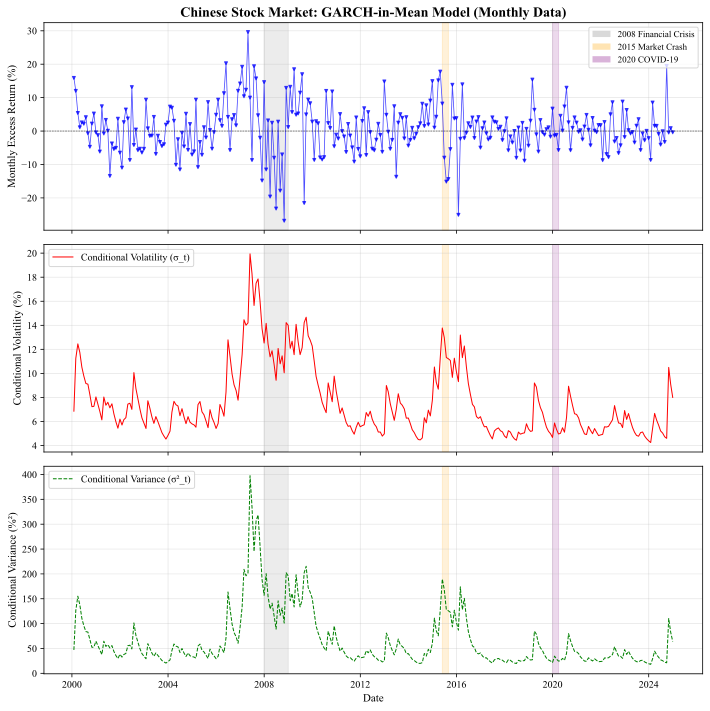

In [324]:
# Visualization: Monthly GARCH-in-Mean Results
import matplotlib.pyplot as plt

# Extract conditional volatility and variance from fitted results
conditional_volatility_mon = res_mon.conditional_volatility
conditional_variance_mon = conditional_volatility_mon**2
returns_mon = reg_mon['ret']

# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# First plot: Returns
ax1.plot(returns_mon.index, returns_mon.values, color='blue', linewidth=0.8, 
         marker='v', markersize=3, alpha=0.7, label='Excess Returns')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax1.set_ylabel('Monthly Excess Return (%)', fontsize=11)
ax1.set_title('Chinese Stock Market: GARCH-in-Mean Model (Monthly Data)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')

# Second plot: Conditional Volatility (Standard Deviation)
ax2.plot(conditional_volatility_mon.index, conditional_volatility_mon.values, 
         color='red', linewidth=1.0, label='Conditional Volatility (σ_t)')
ax2.set_ylabel('Conditional Volatility (%)', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left')

# Third plot: Conditional Variance
ax3.plot(conditional_variance_mon.index, conditional_variance_mon.values, 
         color='green', linewidth=1.0, linestyle='--',label='Conditional Variance (σ²_t)')
ax3.set_ylabel('Conditional Variance (%²)', fontsize=11)
ax3.set_xlabel('Date', fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.legend(loc='upper left')

# Mark important events on all subplots
for ax in [ax1, ax2, ax3]:
    # 2008 Financial Crisis
    ax.axvspan(pd.Timestamp('2008-01-01'), pd.Timestamp('2009-01-01'), 
               alpha=0.15, color='gray')
    # 2015 Stock Market Crash
    ax.axvspan(pd.Timestamp('2015-06-01'), pd.Timestamp('2015-09-01'), 
               alpha=0.15, color='orange')
    # 2020 COVID-19 Pandemic
    ax.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-04-01'), 
               alpha=0.15, color='purple')

# Add legend for historical events on the first plot
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='gray', alpha=0.3, label='2008 Financial Crisis'),
    Patch(facecolor='orange', alpha=0.3, label='2015 Market Crash'),
    Patch(facecolor='purple', alpha=0.3, label='2020 COVID-19')
]
ax1.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.savefig('images/GARCH_M_Monthly_Analysis.png', dpi=300, bbox_inches='tight')
plt.show();

# 预测波动率

In [ ]:
# 用月度数据做 “已实现波动率（RV3）的自回归检验”
reg_data['lRV3'] = reg_data['RV3'].shift(1)
model_rv = smf.ols('RV3~ lRV3',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_rv.summary())

                            OLS Regression Results                            
Dep. Variable:                    RV3   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     29.40
Date:                Sun, 16 Nov 2025   Prob (F-statistic):           1.22e-07
Time:                        18:02:41   Log-Likelihood:                 1036.2
No. Observations:                 300   AIC:                            -2068.
Df Residuals:                     298   BIC:                            -2061.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0035      0.001      6.384      0.0

## 换手率 Turnover

### 换手率 (Turnover): 理论与实践

换手率是衡量市场流动性和投资者交易活跃度的重要指标，在学术研究和实际交易中都具有重要意义。

---

## 一、基本概念

**定义**：换手率（Turnover Ratio）是指在一定时期内市场中股票转手买卖的频率，是反映股票流通性强弱的指标之一。

$$
\text{换手率} = \frac{\text{某一时期内的成交量}}{\text{流通股本}} \times 100\%
$$

- **月度换手率**：当月成交量 / 当月平均流通股本
- **年度换手率**：全年成交量 / 年平均流通股本

---

## 二、学术研究视角

### 1. 换手率与收益率的关系

**异质信念假说 (Heterogeneous Beliefs)**：
- Miller (1977) 提出，当投资者对股票价值存在分歧时，乐观者愿意支付更高价格
- 高换手率反映了投资者意见分歧程度
- 预测：**高换手率 → 未来低收益**（过度定价后的反转）

**流动性溢价 (Liquidity Premium)**：
- Amihud & Mendelson (1986) 流动性资产定价理论
- 高换手率 = 高流动性 → 投资者要求的风险溢价更低
- 预测：**高换手率 → 未来低收益**

**关键文献**：
- **Datar, Naik & Radcliffe (1998)**: 发现换手率与股票收益率负相关
- **Chordia, Subrahmanyam & Anshuman (2001)**: 换手率可以预测横截面收益
- **Gervais, Kaniel & Mingelgrin (2001)**: 高交易量（高换手率）后股票短期表现好，但长期表现差

### 2. 换手率与波动率

**正相关关系**：
$$
\sigma_t^2 = f(\text{Turnover}_t, \text{其他因素})
$$

- 高换手率通常伴随高波动率
- 反映市场不确定性和信息流动
- **Karpoff (1987)**: 交易量-价格关系的经典文献综述

### 3. 换手率的时间序列特征

**持续性 (Persistence)**：
- 换手率具有很强的自相关性
- AR模型：$\text{Turnover}_t = \alpha + \beta \cdot \text{Turnover}_{t-1} + \varepsilon_t$
- 投资者习惯和市场结构导致的惯性

**周期性 (Cyclicality)**：
- 牛市时换手率上升（投资者积极参与）
- 熊市时换手率下降（观望情绪浓厚）
- 可作为市场情绪指标

---

## 三、交易实践视角

### 1. 市场情绪指标

**过热信号**：
- 换手率 > 10%：市场交易极度活跃，可能过热
- 换手率 3%-7%：正常交易活跃度
- 换手率 < 1%：市场冷清，流动性不足

**A股市场特征**：
- 中国A股市场换手率长期高于成熟市场（散户主导）
- 美国市场年换手率约 100%-150%
- 中国A股市场年换手率曾超过 500%（2015年）

### 2. 技术分析应用

**量价配合**：
- 价升量增（换手率上升）：健康上涨，可持续
- 价升量减（换手率下降）：上涨乏力，警惕反转
- 价跌量增（换手率上升）：恐慌性抛售或换手筑底
- 价跌量减（换手率下降）：下跌动能衰竭，可能见底

**异常换手率**：
- 个股换手率突然放大 5-10 倍：可能有重大消息或主力行为
- 新股上市初期换手率超高（换手充分）

### 3. 风险管理

**流动性风险**：
- 低换手率股票：买卖价差大，冲击成本高
- 机构投资者偏好中高换手率股票（易于进出）

**交易策略**：
- **高频交易**：需要高换手率保证流动性
- **长期投资**：可容忍较低换手率

---

## 四、中国市场的特殊性

### 1. 制度因素

- **T+1 交易制度**：限制日内回转交易，影响换手率
- **涨跌停板**：10% 涨跌幅限制影响换手率波动
- **融资融券**：2010年推出后增加了市场换手率

### 2. 投资者结构

- **散户主导**：中国散户占比高，导致换手率远高于成熟市场
- **投机性强**：追涨杀跌行为导致换手率波动剧烈
- **机构化趋势**：近年来机构投资者增加，换手率有所下降

### 3. 实证发现（中国市场）

- **周内效应**：周一换手率较低，周五较高
- **节假日效应**：长假前换手率下降（锁定利润或规避风险）
- **板块轮动**：不同板块换手率轮流上升

---

## 五、研究假说

### 在波动率预测中的应用

$$
\text{RV}_{t+1} = \alpha + \beta_1 \cdot \text{RV}_t + \beta_2 \cdot \text{Turnover}_t + \varepsilon_{t+1}
$$

**理论预期**：
- $\beta_2 > 0$：高换手率预示未来高波动率
- 换手率捕捉投资者情绪和信息不对称

**Paye (2012) 发现**：
- 宏观经济变量（如换手率）可以预测总体市场波动率
- 样本外预测效果优于纯时间序列模型

---

## 六、经验法则 (Rules of Thumb)

| 换手率范围 | 市场状态 | 投资建议 |
|-----------|---------|---------|
| < 1% | 冷清，关注度低 | 谨慎参与，流动性风险大 |
| 1% - 3% | 正常交易 | 可正常交易 |
| 3% - 7% | 活跃交易 | 市场健康，适合短线 |
| 7% - 15% | 高度活跃 | 警惕过热，注意风险 |
| > 15% | 异常活跃 | 极度投机，高风险 |

---

**核心要点**：
1. 换手率是流动性和市场情绪的综合指标
2. 学术研究发现换手率与未来收益率负相关（过度交易、流动性溢价）
3. 实践中用于判断市场热度、验证趋势真实性
4. 中国市场换手率显著高于国际水平，反映市场特征
5. 可用于预测波动率和辅助风险管理

In [ ]:
# 读取 “月度换手率数据文件”
Turnover = pd.read_csv('Turnover_mon2024.csv')
Turnover['month'] = pd.date_range(start='1990-12-31', periods=len(Turnover), freq='ME')
Turnover.set_index('month', inplace=True)
Turnover.sort_index(inplace=True)
Turnover

,to_v,to_m
month,,
1990-12-31,0.009403,0.009754
1991-01-31,0.012623,0.031899
1991-02-28,0.042994,0.046496
1991-03-31,0.006471,0.016755
...,...,...
2024-09-30,0.235540,0.231543
2024-10-31,0.424766,0.464635
2024-11-30,0.493320,0.514568
2024-12-31,0.454830,0.439975


## 换手率图

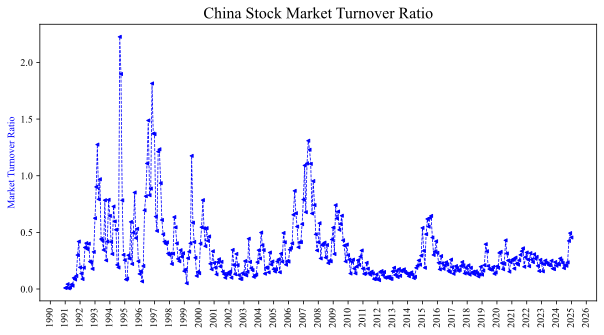

In [343]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(Turnover['to_v'],color='blue',marker='<',linewidth=0.8,
         markersize=3,
         linestyle='--',label='Market Turnover Ratio')
ax1.set_ylabel('Market Turnover Ratio',color='blue')
#ax1.set_xlabel('Month')
data_format = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(data_format)
ax1.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation = 90)

plt.title('China Stock Market Turnover Ratio', fontsize=16)
plt.show();

In [ ]:
# RV and Turnover correlation
#  计算 2000 年 1 月 - 2024 年 12 月期间，月度已实现波动率（RV3）与月度换手率（to_v）之间的相关系数
reg_data_turnover = pd.merge(reg_data,Turnover,on='month',how='left')
test = reg_data_turnover['2000-01':'2024-12']
test[['RV3','to_v']].corr()

,RV3,to_v
RV3,1.000000,0.472061
to_v,0.472061,1.000000


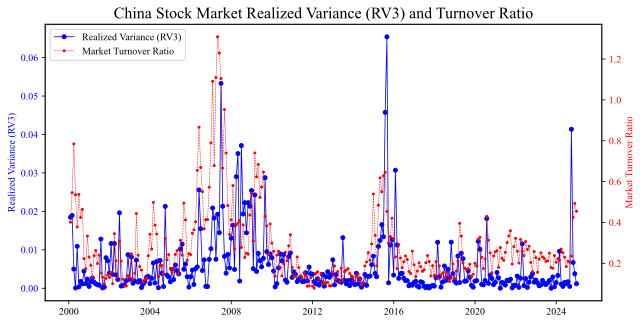

In [363]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(test['RV3'],color='blue',marker='o',linewidth=0.8,
         markersize=4,
         linestyle='-',label='Realized Variance (RV3)')
ax1.set_ylabel('Realized Variance (RV3)',color='blue')
ax1.tick_params(axis='y', labelcolor='blue')   
ax1.set_title("China Stock Market Realized Variance (RV3) and Turnover Ratio", fontsize=16)

ax1.set_ylabel('Realized Variance (RV3)',color='blue')

ax2 = ax1.twinx()
ax2.plot(test['to_v'],color='red',marker='o',linewidth=0.5,
         markersize=2,
         linestyle='--',label='Market Turnover Ratio')
ax2.set_ylabel('Market Turnover Ratio',color='red')
ax2.tick_params(axis='y', labelcolor='red')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.show();

In [ ]:
# 研究 上一个月的波动率（lRV3） 和 上一个月的换手率（lto_v） 这两个变量，对 当前月份的波动率（RV3） 的 联合预测能力
reg_data_turnover['lto_v'] = reg_data_turnover['to_v'].shift(1)
model_turnover = smf.ols('RV3 ~ lRV3 + lto_v',
                 data=reg_data_turnover['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_turnover.summary())

                            OLS Regression Results                            
Dep. Variable:                    RV3   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     20.65
Date:                Sun, 16 Nov 2025   Prob (F-statistic):           3.99e-09
Time:                        18:08:31   Log-Likelihood:                 1051.3
No. Observations:                 300   AIC:                            -2097.
Df Residuals:                     297   BIC:                            -2086.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.001      0.686      0.4

In [ ]:
#先用 “预测出的波动率（CV）” 解释 “当前股票收益率（ret）,再用“预测波动率（CV）+滞后市净率（lpb）”解释收益率
reg_data_turnover['CV'] = model_turnover.fittedvalues
reg_data_turnover['lpb'] = reg_data_turnover['pb'].shift(1)
model_cv = smf.ols('ret ~ CV',
                 data=reg_data_turnover['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
model_cv2 = smf.ols('ret ~ CV + lpb',
                    data=reg_data_turnover['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cv.summary())
print(model_cv2.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     2.678
Date:                Sun, 16 Nov 2025   Prob (F-statistic):              0.103
Time:                        18:08:31   Log-Likelihood:                 353.38
No. Observations:                 300   AIC:                            -702.8
Df Residuals:                     298   BIC:                            -695.4
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0121      0.010     -1.257      0.2

In [366]:
Q_turnover = Turnover.resample('QE').sum()
Q_turnover.index.name = 'Q'
Q_turnover

,to_v,to_m
Q,,
1990-12-31,0.009403,0.009754
1991-03-31,0.062088,0.095150
1991-06-30,0.083958,0.098678
1991-09-30,0.297957,0.331421
...,...,...
2024-03-31,0.708789,0.775176
2024-06-30,0.666519,0.702937
2024-09-30,0.651922,0.660971
2024-12-31,1.372916,1.419178


In [ ]:
# 在季度数据层面，检验 “上一季度的波动率（lRV3）” 和 “上一季度的换手率（lto_v）” 对 “当前季度的波动率（RV3）” 的联合预测能力
Qreg_data_turnover = pd.merge(Qreg_data, Q_turnover, on='Q', how='left')
Qreg_data_turnover['lto_v'] = Qreg_data_turnover['to_v'].shift(1)
model_qturnover = smf.ols('RV3 ~ lRV3 + lto_v',
                 data=Qreg_data_turnover['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
print(model_qturnover.summary())

                            OLS Regression Results                            
Dep. Variable:                    RV3   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     10.34
Date:                Sun, 16 Nov 2025   Prob (F-statistic):           8.51e-05
Time:                        18:08:31   Log-Likelihood:                 271.93
No. Observations:                 100   AIC:                            -537.9
Df Residuals:                      97   BIC:                            -530.1
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0028      0.003      0.913      0.3

In [369]:
# 在季度数据层面，构建 “两步预测模型” 并逐步加入控制变量
Qreg_data_turnover['CV'] = model_qturnover.fittedvalues
Qreg_data_turnover['lpb'] = Qreg_data_turnover['pb'].shift(1)
model_qcv = smf.ols('ret ~ CV',
                 data=Qreg_data_turnover['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
model_qcv2 = smf.ols('ret ~ CV + lpb',
                    data=Qreg_data_turnover['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
model_qcv3 = smf.ols('ret ~ CV + lpb + lcpi',
                    data=Qreg_data_turnover['2000-01':'2024-12']).fit(
                        cov_type='HAC', cov_kwds={'maxlags': 2})
print(model_qcv.summary())
print(model_qcv2.summary())
print(model_qcv3.summary()) 

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     3.748
Date:                Sun, 16 Nov 2025   Prob (F-statistic):             0.0557
Time:                        18:12:46   Log-Likelihood:                 49.443
No. Observations:                 100   AIC:                            -94.89
Df Residuals:                      98   BIC:                            -89.68
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0465      0.031     -1.517      0.1